<h1 style="text-align:center;font-weight:bold">SentimentAnalysis_CountTfidf</h1>

Sentiment analysis is important because it allows understanding the emotions, opinions and attitudes expressed by people in relation to certain expectations. This is critical for businesses and organizations as it provides valuable insights into audience perception and helps make strategic decisions. It is widely used in marketing to measure reception of products and advertising campaigns, identify strengths and weaknesses, and adjust strategies. 

It is also applied on social media and news platforms, allowing you to identify emerging trends, monitor brand trust and respond to negative comments. In addition, it assists the government and institutions in assessing public opinion and adapting public policies according to society's needs. In short, sentiment analysis plays a crucial role in understanding human emotions and emotions, guiding business strategies, improving customer relationships, and informing decisions both at the corporate and public levels.

### Libraries

In [1]:
# Suppress warnings.
import warnings
warnings.filterwarnings('ignore')

# Import the numpy and pandas package.
import numpy as np
import pandas as pd
import string

# Visualisation Libraries.
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Loading NLTK.
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Convert a set of texts into a word count matrix.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Training & Evaluation.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# Checking missing value formats and read data.
missing_value_formats = ["na", "n.a.", "?", "NA", "n/a", "--"]
df = pd.read_csv('train.tsv', sep = '\t', na_values=missing_value_formats)

# Checking missing values.
if df.isna().sum().sum() == 0:
    print("No missing values.")
else:
    print("There are missing values in the data.")

# Display first and last 5 records.
display(df.head())
display(df.tail())

# Display shape.
print("Shape of the dataset:", df.shape)
print("\nInformation about the dataset:\n")

# Returns the info.
df.info()

There are missing values in the data.


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


,PhraseId,SentenceId,Phrase,Sentiment
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2
156059,156060,8544,chortles,2


Shape of the dataset: (156060, 4)

Information about the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156058 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


The given dataset seems to be suitable for performing text analysis, as it contains the relevant leaders for this type of task, such as "Phrase" and "Sentiment". Let's explore these individual variables, but first I'll check some data EDA details.

In [3]:
# Check for duplicate rows.
duplicate_rows_df = df[df.duplicated()]

# Print the number of duplicate rows found and additional information.
if duplicate_rows_df.shape[0] > 0:
    print("The dataset contains", duplicate_rows_df.shape[0], "duplicate rows.")
    print("Here are the first few duplicate rows:")
    print(duplicate_rows_df.head())
else:
    print("No duplicate rows were found in the dataset.")

No duplicate rows were found in the dataset.


In [4]:
# Check for null values.
null_values = df.isnull().sum().sort_values()

# Print the number and percentage of null values found for each column.
print("Null values per column:")
print(null_values)

Null values per column:
PhraseId      0
SentenceId    0
Sentiment     0
Phrase        2
dtype: int64


In [5]:
# Removing null values
df = df.dropna()

# Check for null values.
null_values = df.isnull().sum().sort_values()

# Print the number and percentage of null values found for each column.
print("Null values per column:")
print(null_values)

Null values per column:
PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64


1. **PhraseId:** This column represents a unique identifier assigned to each phrase in the dataset. This variable can be useful for tracking and identifying specific phrases, but it may not be directly relevant to sentiment analysis.


2. **SentenceId:** This column indicates the unique identifier assigned to each sentence in the dataset. Phrases can be grouped into sentences based on this identifier. While this variable can be useful for context and clustering analyses, it may not have a direct impact on sentiment analysis.


3. **Sentence:** This column contains the sentences or excerpts of text that will be analyzed in terms of sentiments. This variable is of central importance for sentiment analysis as it represents the actual text in which to be interested in identifying the underlying sentiment.


4. **Sentiment:** This column represents the target variable or label for the sentiment analysis. It is a category or numeric value to indicate the sentiment associated with each phrase. Depending on the specific dataset, this variable can have different scales or categories. For example, it could be a numeric scale from 1 to 5, where each number represents a different sentiment (eg negative, neutral, positive).

###   Let's check it out !!!

2    79580
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


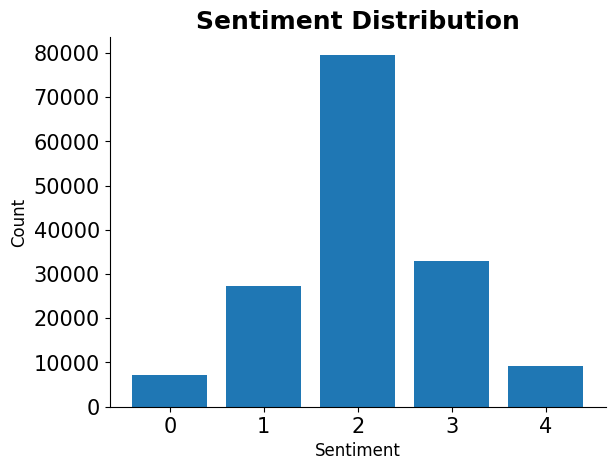

In [6]:
# Count the categories in the 'Sentiment' column.
sentiment_counts = df['Sentiment'].value_counts()

# Display sentiment count.
print(sentiment_counts)

# Configure the bar chart view.
plt.bar(sentiment_counts.index, sentiment_counts)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Sentiment Distribution', fontsize=18, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

As I have limited information about the sentiment labels in my dataset, I will conduct a brief exploratory investigation by examining 5 sentiments from each label. This will help me gain a better understanding of the sentiment representation within the dataset. By examining a small sample of sentiments from each label, I aim to gain insights into the range of sentiments present in the dataset and establish a preliminary understanding of the sentiments associated with each label. This exploratory analysis will provide valuable context for subsequent sentiment analysis tasks.

In [7]:
# Dictionary to store the phrases of each label.
frases_por_rotulo = {}

# Read 4 sentences from each label from 0 to 4.
for label in range(5):
    frases_por_rotulo[label] = df[df['Sentiment'] == label]['Phrase'].head(4).tolist()

for label, frases in frases_por_rotulo.items():
    print(f"Frases com rótulo {label}:")
    for frase in frases:
        print(f"- {frase}")
    print()

Frases com rótulo 0:
- would have a hard time sitting through this one
- have a hard time sitting through this one
- Aggressive self-glorification and a manipulative whitewash
- self-glorification and a manipulative whitewash

Frases com rótulo 1:
- A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
- the gander , some of which occasionally amuses but none of which amounts to much of a story
- but none of which amounts to much of a story
- none of which amounts to much of a story

Frases com rótulo 2:
- A series of escapades demonstrating the adage that what is good for the goose
- A series
- A
- series

Frases com rótulo 3:
- good for the goose
- good
- amuses
- This quiet , introspective and entertaining independent

Frases com rótulo 4:
- This quiet , introspective and entertaining independent is worth seeking .
- quiet , introspective and enterta

Based on the sentences mentioned above, it appears that the sentiment scale in your dataset ranges from negative 0 to positive 4, with the neutral sentiment positioned at the center.

<h3 style="text-align:center;font-weight:bold">Text Preprocessing, Feature Extraction, and Model Training & Evaluation</h3>

1. Conversion of columns 'Phrase' and 'Sentiment' to string data type:
     - This step uses the `astype()` method to convert the 'Phrase' and 'Sentiment' columns to the string data type. This is done to ensure that the data in these voices is treated as text.

2. Filling in the missing values in the spoken words 'Phrase' and 'Sentiment':
     - This step uses the `fillna()` method to fill in the missing values in the 'Phrase' and 'Sentiment' columns with an empty string (''). This is done to avoid problems during further data processing.

3. Tokenization for removing unwanted elements:
     - This step uses a tokenizer called `RegexpTokenizer` to remove unwanted data elements such as symbols and numbers. The tokenizer is configured with a regular expression `[a-zA-Z]+`, which is case-only. This helps to clean up the texts and keep only the relevant words.

4. Creation of the CountVectorizer with the desired settings:
     - In this step, a `CountVectorizer` object is created with the desired settings. `CountVectorizer` is a text pre-processing tool that transforms a set of text documents into a term count matrix. In this case, the specified settings are: convert all words to lowercase (`lowercase=True`), "stop words" call remover (common words that usually do not create for sorting, such as "a", "o", " e", etc.) using a list of English stop words (`stop_words='english'`), and use the previously defined tokenizer to tokenize the text (`tokenizer=tokenizer.tokenize`).

5. Applying the CountVectorizer to the 'Phrase' column of the DataFrame:
     - Finally, the CountVectorizer is applied to the 'Phrase' column of the DataFrame using the `fit_transform()` method. This performs the CountVectorizer fit to the data and then transforms the 'Phrase' column into a term count matrix. The result is assigned to the `text_counts` variable.


In [8]:
# Convert 'Phrase' and 'Sentiment' columns to string data type.
df['Phrase'] = df['Phrase'].astype(str)
df['Sentiment'] = df['Sentiment'].astype(str)

# Fill missing values in 'Phrase' and 'Sentiment' columns.
df['Phrase'].fillna('', inplace=True)
df['Sentiment'].fillna('', inplace=True)

# Split the DataFrame into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer to remove unwanted elements from our data like symbols and numbers
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

# Create CountVectorizer with desired configurations
cv = CountVectorizer(lowercase=True, stop_words='english', tokenizer=tokenizer.tokenize)

# Apply CountVectorizer to the 'Phrase' column in the training set
text_counts_train = cv.fit_transform(df_train['Phrase'])

#### Performance Evaluation of the Multinomial Naive Bayes Classification Model with Cross Validation (CountVectorizer)

In this part of the code, the performance evaluation of a Naive Bayes Multinomial classification model using 5-fold cross-validation is performed. The evaluation metrics, including accuracy, precision, recall and F1-score, are left for each fold and then their averages are satisfied.

In [9]:
skf = StratifiedKFold(n_splits=5)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Loop folds.
for train_index, test_index in skf.split(text_counts_train, df_train['Sentiment']):
    X_train_fold, X_test_fold = text_counts_train[train_index], text_counts_train[test_index]
    y_train_fold, y_test_fold = df_train['Sentiment'].iloc[train_index], df_train['Sentiment'].iloc[test_index]

    # Train the Naive Bayes Multinomial model.
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train_fold, y_train_fold)

    # Perform predictions.
    nb_predicted = nb_clf.predict(X_test_fold)

    # Calculate metrics.
    accuracy_scores.append(metrics.accuracy_score(y_test_fold, nb_predicted))
    precision_scores.append(metrics.precision_score(y_test_fold, nb_predicted, average='weighted'))
    recall_scores.append(metrics.recall_score(y_test_fold, nb_predicted, average='weighted'))
    f1_scores.append(metrics.f1_score(y_test_fold, nb_predicted, average='weighted'))

# Calculate the averages of the metrics for all folds.
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1_score = sum(f1_scores) / len(f1_scores)
print("Multinomial Naive Bayes Average Accuracy: {:.2f}".format(avg_accuracy))
print("Multinomial Naive Bayes Average Precision: {:.2f}".format(avg_precision))
print("Multinomial Naive Bayes Average Recall: {:.2f}".format(avg_recall))
print("Multinomial Naive Bayes Average F1-score: {:.2f}".format(avg_f1_score))

Multinomial Naive Bayes Average Accuracy: 0.60
Multinomial Naive Bayes Average Precision: 0.59
Multinomial Naive Bayes Average Recall: 0.60
Multinomial Naive Bayes Average F1-score: 0.59


#### Validation and Prediction of the Naive Bayes Multinomial Classification Model using the Test Set (CountVectorizer)

In this part of the code, the test set (df_test) is used to validate and perform the prediction of the trained model. Sentences from the test set are transformed into term counts using CountVectorizer, and then the Naive Bayes Multinomial model is used to make predictions on these sentences. Performance metrics such as accuracy, precision, recall and F1-score are compared as predictions with the actual test set symbols. Additionally, a DataFrame is created to display a sample of actual and predicted results.

In [10]:
# At the end, for validation and prediction, use the test set (df_test).
text_counts_test = cv.transform(df_test['Phrase'])
predictions = nb_clf.predict(text_counts_test)

# Create a DataFrame with the actual and predicted values.
results_df = pd.DataFrame({'Actual': df_test['Sentiment'], 'Predicted': predictions})

# Calculate performance metrics.
accuracy = metrics.accuracy_score(results_df['Actual'], results_df['Predicted'])
precision = metrics.precision_score(results_df['Actual'], results_df['Predicted'], average='weighted')
recall = metrics.recall_score(results_df['Actual'], results_df['Predicted'], average='weighted')
f1_score = metrics.f1_score(results_df['Actual'], results_df['Predicted'], average='weighted')

# Print the metrics.
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))

# Display the first 20 samples.
sample_results = results_df.sample(n=20, random_state=42)
print(sample_results)

Accuracy: 0.60
Precision: 0.59
Recall: 0.60
F1 Score: 0.59
       Actual Predicted
54489       1         2
129027      2         3
97611       2         2
59043       2         3
24415       2         2
82955       3         2
151348      2         3
49349       2         2
23607       2         2
104882      2         2
138358      2         2
118487      1         1
35102       4         3
93411       2         2
51068       2         2
152046      1         2
59536       1         2
93971       3         3
135467      2         2
31420       1         1


In the next step, we will repeat the parsing process, but with a different text extractor. Now, we will use `TfidfVectorizer` instead of `CountVectorizer`. ' and 'Sentiment' for the string type, fill in the missing values, split the DataFrame into training and test sets, then apply `TfidfVectorizer` to the training set. So you're ready to go with training and evaluation of the model using this new approach.

In [11]:
# Convert 'Phrase' and 'Sentiment' columns to string data type
df['Phrase'] = df['Phrase'].astype(str)
df['Sentiment'] = df['Sentiment'].astype(str)

# Fill missing values in 'Phrase' and 'Sentiment' columns
df['Phrase'].fillna('', inplace=True)
df['Sentiment'].fillna('', inplace=True)

# Split the DataFrame into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer to remove unwanted elements from our data like symbols and numbers
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

# Create TfidfVectorizer with desired configurations
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', tokenizer=tokenizer.tokenize)

# Apply TfidfVectorizer to the 'Phrase' column in the training set
text_counts_train = tfidf.fit_transform(df_train['Phrase'])

#### Performance Evaluation of the Multinomial Naive Bayes Classification Model with Cross Validation (TfidfVectorizer)

In [12]:
skf = StratifiedKFold(n_splits=5)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Loop folds.
for train_index, test_index in skf.split(text_counts_train, df_train['Sentiment']):
    X_train_fold, X_test_fold = text_counts_train[train_index], text_counts_train[test_index]
    y_train_fold, y_test_fold = df_train['Sentiment'].iloc[train_index], df_train['Sentiment'].iloc[test_index]

    # Train the Naive Bayes Multinomial model.
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train_fold, y_train_fold)

    # Perform predictions.
    nb_predicted = nb_clf.predict(X_test_fold)

    # Calculate metrics.
    accuracy_scores.append(metrics.accuracy_score(y_test_fold, nb_predicted))
    precision_scores.append(metrics.precision_score(y_test_fold, nb_predicted, average='weighted'))
    recall_scores.append(metrics.recall_score(y_test_fold, nb_predicted, average='weighted'))
    f1_scores.append(metrics.f1_score(y_test_fold, nb_predicted, average='weighted'))

# Calculate the averages of the metrics for all folds.
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1_score = sum(f1_scores) / len(f1_scores)
print("Multinomial Naive Bayes Average Accuracy: {:.2f}".format(avg_accuracy))
print("Multinomial Naive Bayes Average Precision: {:.2f}".format(avg_precision))
print("Multinomial Naive Bayes Average Recall: {:.2f}".format(avg_recall))
print("Multinomial Naive Bayes Average F1-score: {:.2f}".format(avg_f1_score))

Multinomial Naive Bayes Average Accuracy: 0.58
Multinomial Naive Bayes Average Precision: 0.57
Multinomial Naive Bayes Average Recall: 0.58
Multinomial Naive Bayes Average F1-score: 0.53


#### Validation and Prediction of the Naive Bayes Multinomial Classification Model using the Test Set (TfidfVectorizer)

In [13]:
# At the end, for validation and prediction, use the test set (df_test)
text_counts_test = cv.transform(df_test['Phrase'])
predictions = nb_clf.predict(text_counts_test)

# Calculate performance metrics.
accuracy = metrics.accuracy_score(results_df['Actual'], results_df['Predicted'])
precision = metrics.precision_score(results_df['Actual'], results_df['Predicted'], average='weighted')
recall = metrics.recall_score(results_df['Actual'], results_df['Predicted'], average='weighted')
f1_score = metrics.f1_score(results_df['Actual'], results_df['Predicted'], average='weighted')

# Print the metrics.
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))

# Create a DataFrame with the actual and predicted values.
results_df = pd.DataFrame({'Actual': df_test['Sentiment'], 'Predicted': predictions})

# Display the first 20 samples.
sample_results = results_df.sample(n=20, random_state=42)
print(sample_results)

Accuracy: 0.60
Precision: 0.59
Recall: 0.60
F1 Score: 0.59
       Actual Predicted
54489       1         2
129027      2         3
97611       2         2
59043       2         3
24415       2         2
82955       3         2
151348      2         3
49349       2         2
23607       2         2
104882      2         2
138358      2         2
118487      1         1
35102       4         3
93411       2         2
51068       2         2
152046      1         2
59536       1         2
93971       3         3
135467      2         2
31420       1         1


Analysis of the results:

The results obtained using TfidfVectorizer in conjunction with the Multinomial Naive Bayes model showed an accuracy of 0.60, precision of 0.59, recall of 0.60 and F1 Score of 0.59. These metrics indicate that the model performed moderately in ranking the sentiments of the sentences in the test set.

When analyzing the specific examples, we can observe that the model did not always hit the correct classification. For example, in the first row of the sample, the expected sentiment was 1, but the previous model as 2. Similar situations occurred in other cases.

Improvement Suggestions:

1. Increase the amount of training data: Adding more labeled examples to the training set can help the model better capture patterns and improve its performance.

2. Experiment with other classification algorithms: In addition to Naive Bayes, it is interesting to explore other classification algorithms, such as Support Vector Machines (SVM) or Random Forests, to see if any of them present superior results.

3. Tuning model hyperparameters: Experimenting with different values of model hyperparameters, such as alpha in Naive Bayes, can influence model performance and improve evaluation metrics.

4. Using class balancing techniques: If the dataset has a significant imbalance between the sentiment classes, balancing techniques such as oversampling or undersampling can be applied to improve the model's ability to handle minority classes.

<h2 style="text-align:center;font-weight:bold">Sentiment Classifier using Machine Learning Model</h2>

The `classify_sentence` function is a sentiment classifier that uses a trained machine learning model. This function takes a sentence as input and performs the classification of the sentiment associated with this sentence. The model used was previously trained with a set of labeled data, where each sentence is associated with a specific feeling. Based on patterns identified during training, the model is able to predict the sentiment of new sentences. This function is useful for analyzing the sentiment expressed in a text and can be applied in several areas, such as analyzing customer opinions and monitoring social networks.

In [14]:
def preprocess_text(text):
    # Remove punctuation.
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Convert to lowercase.
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords.
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the tokens.
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Reconstruct the preprocessed text
    preprocessed_text = " ".join(tokens)

    return preprocessed_text

In [15]:
def classify_sentence(sentence):
    # Convert to string data type
    sentence = str(sentence)

    # Preprocess the input sentence
    preprocessed_sentence = preprocess_text(sentence)

    # Transform the preprocessed sentence using the chosen vectorizer
    sentence_vector = tfidf.transform([preprocessed_sentence])

    # Make predictions using the trained model
    predicted_sentiment = nb_clf.predict(sentence_vector)

    # Print the predicted sentiment
    print("Predicted Sentiment: {}".format(predicted_sentiment[0]))

In [16]:
classify_sentence("this movie is a waste of time")

Predicted Sentiment: 1


In [17]:
classify_sentence("this is an excellent movie")

Predicted Sentiment: 3


<h2 style="text-align:center;font-weight:bold">Reference</h2>

<p>https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk</p>